In [1]:
!pip install torchview

In [2]:
import os
import torch
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchview import draw_graph
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
np.random.seed(49)

In [4]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#Unziping the facial recognition data
!unzip -qq "/content/drive/MyDrive/DeepLearning_2024/FaceRecognition/Dataset/fr_datset.zip"

In [7]:
MODEL_WEIGHTS = "/content/drive/MyDrive/DeepLearning_2024/FaceRecognition/Weights"
MODEL_DIAGRAM = "/content/drive/MyDrive/DeepLearning_2024/FaceRecognition/Model_diagrams"

In [8]:
train_folder = "/content/train"
test_folder = "/content/test"

In [9]:
def classification_metric(y_true,y_pred):
  accuracy  = accuracy_score(y_true, y_pred)
  precision = [round(pres,2) for pres in precision_score(y_true, y_pred, average=None, zero_division=0)]
  recall    = [round(rec,2) for rec in recall_score(y_true, y_pred, average=None, zero_division=0)]
  f1_value  = [round(f1,2) for f1 in f1_score(y_true, y_pred, average=None, zero_division=0)]
  print("Accuracy is:                 ", round(accuracy,3))
  print("Precision of each class is:  ",*precision)
  print("Recall of each class is:     ",*recall)
  print("F1_score of each class is:   ",*f1_value)


def make_confusion_matrix(y_true,y_pred):
  cf_mat = confusion_matrix(y_true,y_pred)
  plt.figure(figsize = (8,8))
  sns.heatmap(cf_mat, annot=True)
  plt.show()

# Data Preprocessing and Loading

In [10]:
label_name = {0:'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

In [11]:
BATCH_SIZE = 64

In [12]:
data_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#load the data
train_dataset = ImageFolder(train_folder, transform=data_transform_train)
test_dataset = ImageFolder(test_folder, transform=data_transform)

train_size = len(train_dataset)
ts=(train_size*75)//100
vs=train_size-ts
train_dataset, val_dataset = data.random_split(train_dataset, [ts,vs])

print(f"Training data length: {len(train_dataset)}\nTesting data length: {len(test_dataset)}\nValidation data length: {len(val_dataset)}")

Training data length: 21531
Testing data length: 7178
Validation data length: 7178


In [13]:
#Load the data into a dataloder of pytorch
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Data Visualization

In [14]:
label_count = {}
for _,label in train_dataset:
  v=label
  label_class=label_name[v]
  label_count[label_class]=label_count.get(label_class,0)+1

label_count={key:label_count[key] for key in label_name.values()}

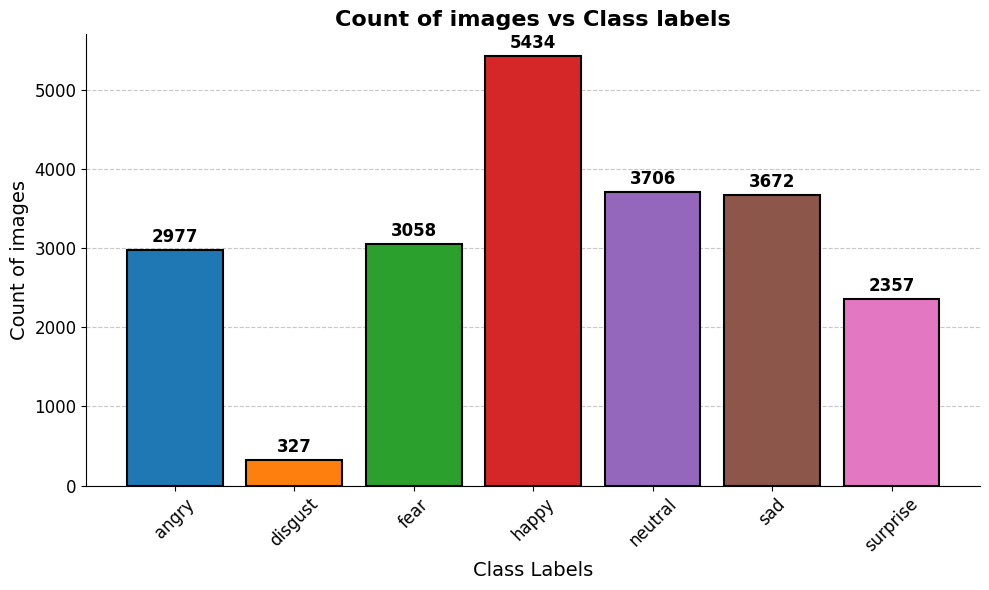

In [15]:
keys = list(label_count.keys())
values = list(label_count.values())

# Define a custom color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(keys, values, color=colors, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Count of images", fontsize=14)
plt.title("Count of images vs Class labels", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_axisbelow(True)

plt.show()

In [16]:
def show_label_images(images, labels):
    images = images.numpy().transpose((0, 2, 3, 1))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    images = images * std + mean
    images = np.clip(images, 0, 1)
    num_images = len(images)
    num_rows = (num_images + 3) // 5

    fig, axes = plt.subplots(num_rows, 5, figsize=(16, 4 * num_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            ax.set_title(f"Label: {label_name[labels[i].item()]}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

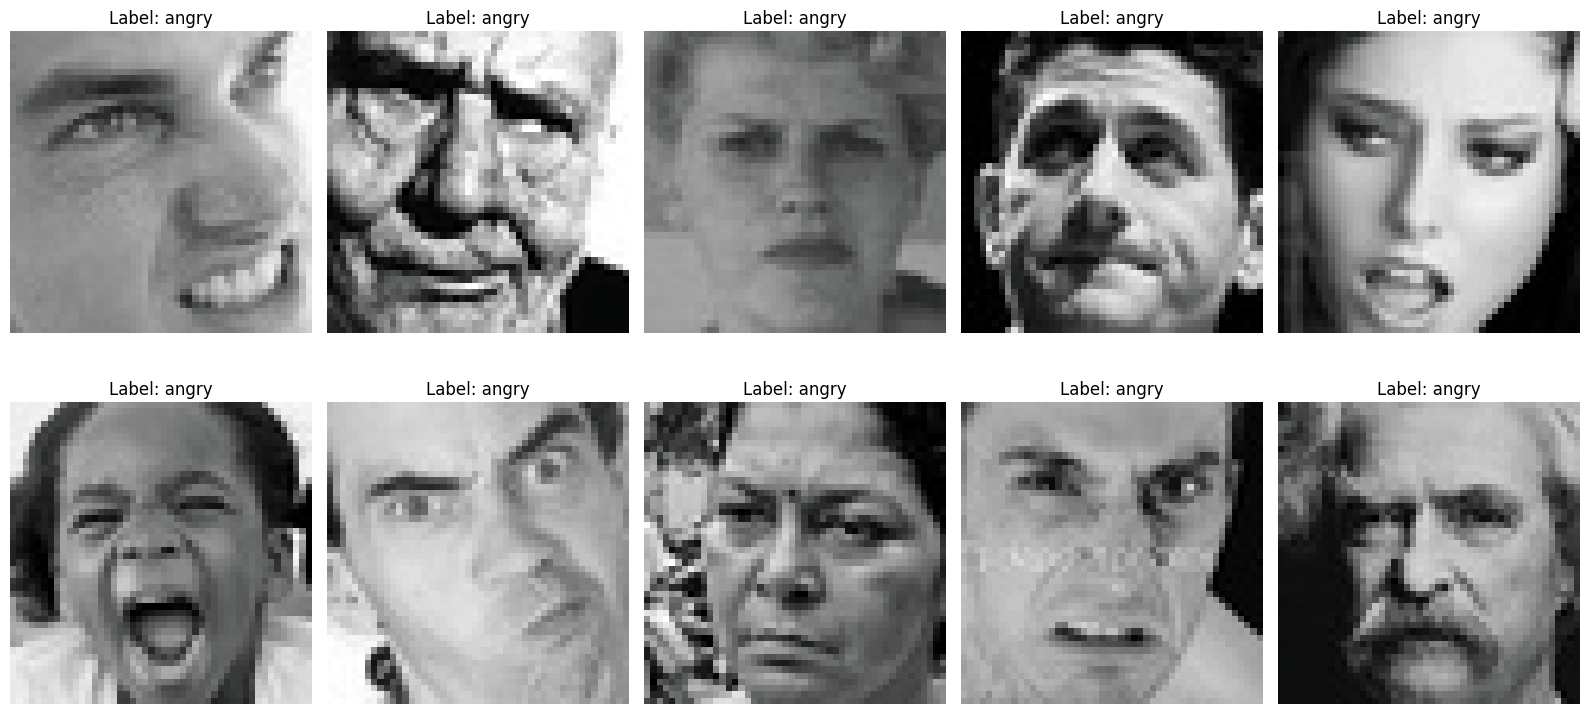

In [17]:
#Test Images without augmentation
for images, labels in test_dataloader:
    if np.random.random()>0.5:
      show_label_images(images[:10], labels[:10])
      break

## Model Training and Testing functions

In [18]:
def model_training(tot_epochs, model, optimizer, criterion, train_loader, val_loader, model_class=None, stopping_threshold=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    threshold = stopping_threshold
    best_loss = float('inf')
    best_accuracy = 0
    best_model_state = None

    for epoch in tqdm(range(tot_epochs)):
        train_loss = 0.0
        val_loss = 0.0
        train_total = 0
        val_total = 0
        train_correct = 0
        val_correct = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            model.train()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item() * images.size(0)

            # Accuracy calculation
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Accuracy on Validation
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        # Appending values at each epoch
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_loss or val_accuracy > best_accuracy:
            best_loss = min(val_loss, best_loss)
            best_accuracy = max(best_accuracy, val_accuracy)
            best_model_state = model.state_dict()
            threshold = stopping_threshold
        else:
            threshold -= 1
        if not threshold:
            break

        print(f"Epoch [{epoch+1}/{tot_epochs}] : Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if model_class is not None:
        model = model_class()
        model.load_state_dict(best_model_state)
        model.to(device)

    info = [train_accuracies, val_accuracies, train_losses, val_losses]
    return model, info

In [19]:
#Function to test the model
def model_testing(model, criterion, data_loader):
  total_correct_predictions = 0
  total_samples = 0
  total_loss = 0.0
  model.eval()
  y_true = np.array([])
  y_pred = np.array([])
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      y_true = np.append(y_true, labels.cpu().numpy())
      y_pred = np.append(y_pred, predicted.cpu().numpy())
  classification_metric(y_true, y_pred)
  print("\n" * 2)
  print("Confusion Matrix")
  make_confusion_matrix(y_true, y_pred)

In [20]:
#Function to plot accuracy and loss graphs
def plot_accuracy_loss(model_info, Title):
  fig, axs = plt.subplots(1, 2,figsize=(12,5))
  fig.suptitle(Title)

  x_axis=range(len(model_info[0]))
  axs[0].plot(x_axis,model_info[0], label="Traning set", marker='o', linestyle='-')
  axs[0].plot(x_axis,model_info[1], label="Validation set", marker='o', linestyle='-')
  axs[0].set(ylabel="Accuracy")
  axs[0].set(xlabel="Epochs")

  axs[1].plot(x_axis,model_info[2], label="Traning set", marker='o', linestyle='-')
  axs[1].plot(x_axis,model_info[3], label="Validation set", marker='o', linestyle='-')
  axs[1].set(ylabel="Loss")
  axs[1].set(xlabel="Epochs")

  plt.legend()
  plt.show()

In [21]:
#One sample input for ploting diagrams
for sample_input,_ in train_dataloader:
  break
sample_input.shape

torch.Size([64, 3, 48, 48])

# CNN Models

# 1. Base CNN model

In [ ]:
class Base_CNN(nn.Module):
    def __init__(self):
        super(Base_CNN, self).__init__()
        self.conv1_layer = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_layer = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1_layer = nn.Linear(1152*4, 256)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)

        self.fc2_layer = nn.Linear(256, 7)

    def forward(self, x):
        out = self.maxpool1(self.dropout1(self.relu1(self.batchnorm1(self.conv1_layer(x)))))
        out = self.maxpool2(self.dropout2(self.relu2(self.batchnorm2(self.conv2_layer(out)))))
        out = torch.flatten(out, 1)
        out = self.dropout3(self.relu3(self.batchnorm3(self.fc1_layer(out))))
        out = self.fc2_layer(out)
        out = F.log_softmax(out, dim=-1)
        return out

In [ ]:
#Saving model diagram
save_path=os.path.join(MODEL_DIAGRAM,"base_cnn_model")
model_graph = draw_graph(Base_CNN(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/DeepLearning_2024/FaceRecognition/Model_diagrams/base_cnn_model.png'

### Model Training

In [ ]:
# Create a base CNN model
cnn_mod = Base_CNN()

# Train your CNN Model
model = cnn_mod.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=30

cnn_mod, cnn_mod_info = model_training(num_epochs, model, optimizer, criterion, train_dataloader, val_dataloader, Base_CNN)

  3%|▎         | 1/30 [00:27<13:05, 27.09s/it]

Epoch [1/30] : Train Loss: 1.7250, Val Loss: 1.6260,  Train Accuracy: 0.3231, Val Accuracy: 0.3720


  7%|▋         | 2/30 [00:51<11:50, 25.38s/it]

Epoch [2/30] : Train Loss: 1.5882, Val Loss: 1.5556,  Train Accuracy: 0.3856, Val Accuracy: 0.4067


 10%|█         | 3/30 [01:15<11:15, 25.01s/it]

Epoch [3/30] : Train Loss: 1.5330, Val Loss: 1.5217,  Train Accuracy: 0.4053, Val Accuracy: 0.4202


 13%|█▎        | 4/30 [01:42<11:07, 25.68s/it]

Epoch [4/30] : Train Loss: 1.4937, Val Loss: 1.4860,  Train Accuracy: 0.4281, Val Accuracy: 0.4310


 17%|█▋        | 5/30 [02:06<10:29, 25.19s/it]

Epoch [5/30] : Train Loss: 1.4619, Val Loss: 1.4642,  Train Accuracy: 0.4374, Val Accuracy: 0.4379


 20%|██        | 6/30 [02:40<11:12, 28.02s/it]

Epoch [6/30] : Train Loss: 1.4325, Val Loss: 1.4449,  Train Accuracy: 0.4515, Val Accuracy: 0.4537


 23%|██▎       | 7/30 [03:07<10:34, 27.58s/it]

Epoch [7/30] : Train Loss: 1.4149, Val Loss: 1.4305,  Train Accuracy: 0.4583, Val Accuracy: 0.4579


 27%|██▋       | 8/30 [03:31<09:46, 26.64s/it]

Epoch [8/30] : Train Loss: 1.3982, Val Loss: 1.4159,  Train Accuracy: 0.4629, Val Accuracy: 0.4593


 30%|███       | 9/30 [03:56<09:10, 26.21s/it]

Epoch [9/30] : Train Loss: 1.3837, Val Loss: 1.4034,  Train Accuracy: 0.4727, Val Accuracy: 0.4675


 33%|███▎      | 10/30 [04:26<09:06, 27.30s/it]

Epoch [10/30] : Train Loss: 1.3684, Val Loss: 1.4163,  Train Accuracy: 0.4765, Val Accuracy: 0.4482


 37%|███▋      | 11/30 [04:51<08:26, 26.65s/it]

Epoch [11/30] : Train Loss: 1.3587, Val Loss: 1.3932,  Train Accuracy: 0.4833, Val Accuracy: 0.4723


 40%|████      | 12/30 [05:25<08:36, 28.70s/it]

Epoch [12/30] : Train Loss: 1.3422, Val Loss: 1.3844,  Train Accuracy: 0.4892, Val Accuracy: 0.4714


 43%|████▎     | 13/30 [05:57<08:27, 29.83s/it]

Epoch [13/30] : Train Loss: 1.3368, Val Loss: 1.3751,  Train Accuracy: 0.4936, Val Accuracy: 0.4739


 47%|████▋     | 14/30 [06:22<07:31, 28.20s/it]

Epoch [14/30] : Train Loss: 1.3239, Val Loss: 1.3840,  Train Accuracy: 0.4915, Val Accuracy: 0.4712


 50%|█████     | 15/30 [06:46<06:45, 27.05s/it]

Epoch [15/30] : Train Loss: 1.3101, Val Loss: 1.3903,  Train Accuracy: 0.4984, Val Accuracy: 0.4668


 53%|█████▎    | 16/30 [07:10<06:04, 26.06s/it]

Epoch [16/30] : Train Loss: 1.2977, Val Loss: 1.3891,  Train Accuracy: 0.5082, Val Accuracy: 0.4689


 57%|█████▋    | 17/30 [07:35<05:36, 25.86s/it]

Epoch [17/30] : Train Loss: 1.2925, Val Loss: 1.3735,  Train Accuracy: 0.5052, Val Accuracy: 0.4710


 60%|██████    | 18/30 [07:59<05:02, 25.23s/it]

Epoch [18/30] : Train Loss: 1.2852, Val Loss: 1.3578,  Train Accuracy: 0.5093, Val Accuracy: 0.4812


 63%|██████▎   | 19/30 [08:23<04:32, 24.78s/it]

Epoch [19/30] : Train Loss: 1.2777, Val Loss: 1.3564,  Train Accuracy: 0.5137, Val Accuracy: 0.4836


 67%|██████▋   | 20/30 [08:45<04:02, 24.20s/it]

Epoch [20/30] : Train Loss: 1.2687, Val Loss: 1.3709,  Train Accuracy: 0.5154, Val Accuracy: 0.4735


 70%|███████   | 21/30 [09:09<03:36, 24.10s/it]

Epoch [21/30] : Train Loss: 1.2630, Val Loss: 1.3547,  Train Accuracy: 0.5236, Val Accuracy: 0.4790


 73%|███████▎  | 22/30 [09:33<03:12, 24.07s/it]

Epoch [22/30] : Train Loss: 1.2552, Val Loss: 1.3660,  Train Accuracy: 0.5238, Val Accuracy: 0.4737


 77%|███████▋  | 23/30 [09:56<02:46, 23.72s/it]

Epoch [23/30] : Train Loss: 1.2520, Val Loss: 1.3395,  Train Accuracy: 0.5265, Val Accuracy: 0.4929


 80%|████████  | 24/30 [10:26<02:33, 25.58s/it]

Epoch [24/30] : Train Loss: 1.2391, Val Loss: 1.3507,  Train Accuracy: 0.5309, Val Accuracy: 0.4847


 83%|████████▎ | 25/30 [11:07<02:30, 30.09s/it]

Epoch [25/30] : Train Loss: 1.2328, Val Loss: 1.3390,  Train Accuracy: 0.5310, Val Accuracy: 0.4838


 87%|████████▋ | 26/30 [11:31<01:52, 28.20s/it]

Epoch [26/30] : Train Loss: 1.2306, Val Loss: 1.3387,  Train Accuracy: 0.5337, Val Accuracy: 0.4844


 90%|█████████ | 27/30 [11:55<01:21, 27.14s/it]

Epoch [27/30] : Train Loss: 1.2231, Val Loss: 1.3262,  Train Accuracy: 0.5360, Val Accuracy: 0.4941


 93%|█████████▎| 28/30 [12:29<00:58, 29.01s/it]

Epoch [28/30] : Train Loss: 1.2212, Val Loss: 1.3400,  Train Accuracy: 0.5400, Val Accuracy: 0.4848


 97%|█████████▋| 29/30 [12:51<00:27, 27.14s/it]

Epoch [29/30] : Train Loss: 1.2040, Val Loss: 1.3242,  Train Accuracy: 0.5449, Val Accuracy: 0.4886


100%|██████████| 30/30 [13:25<00:00, 26.86s/it]

Epoch [30/30] : Train Loss: 1.2068, Val Loss: 1.3294,  Train Accuracy: 0.5412, Val Accuracy: 0.4928


### Accuracy plots

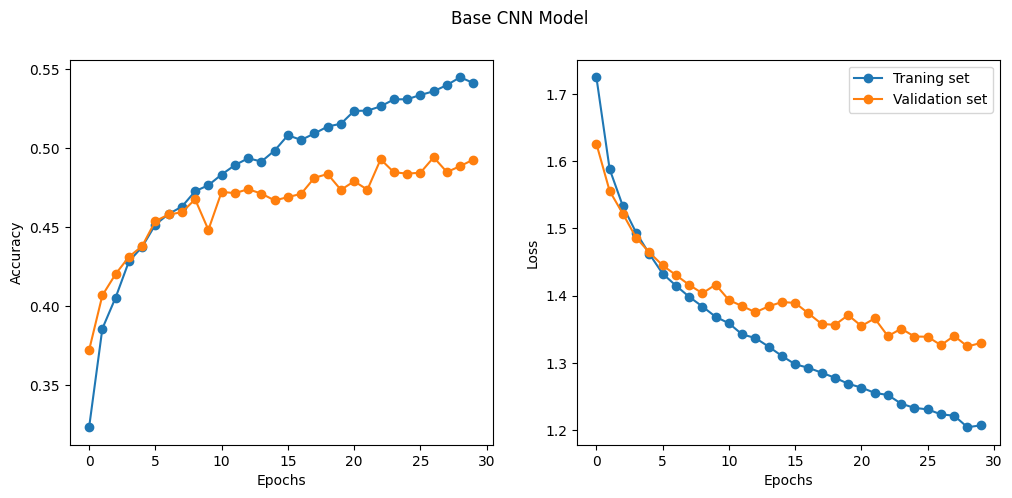

In [ ]:
plot_accuracy_loss(cnn_mod_info, "Base CNN Model")

### Model Testing

Accuracy is:                  0.513
Precision of each class is:   0.46 0.9 0.44 0.79 0.58 0.32 0.73
Recall of each class is:      0.36 0.08 0.21 0.72 0.32 0.74 0.62
F1_score of each class is:    0.41 0.15 0.29 0.75 0.41 0.44 0.67



Confusion Matrix


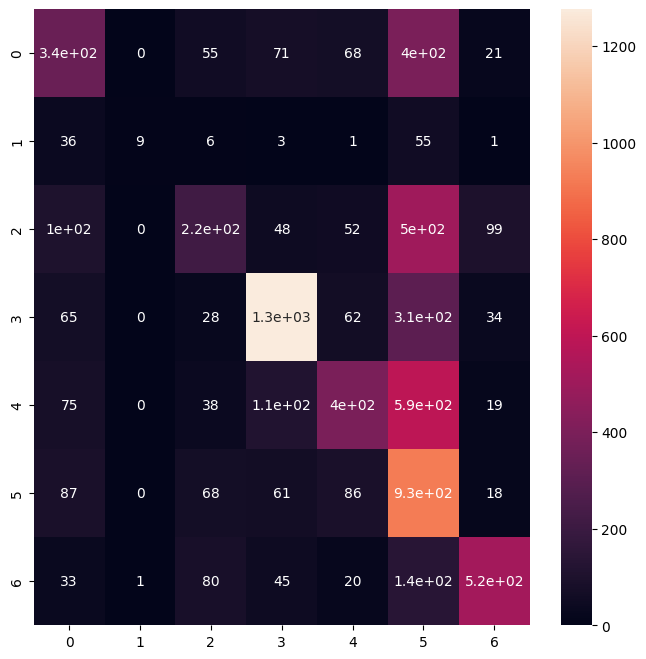

In [ ]:
model_testing(cnn_mod, criterion, test_dataloader)

In [ ]:
save_path=os.path.join(MODEL_WEIGHTS, "base_cnn_model.pth")
torch.save(cnn_mod, save_path)

# 2. Resnet Model

In [ ]:
import torch
import torch.nn as nn

# Define the basic building blocks of a ResNet: Residual Block and Residual Layer
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        #TODO: you need to implement the forward function
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.log_softmax(self.fc(x), dim=-1)

        return x

# Create a ResNet model
resnet = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=7)

In [ ]:
#Saving model diagram
save_path=os.path.join(MODEL_DIAGRAM,"resnet_cnn_model")
model_graph = draw_graph(ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=7), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/DeepLearning_2024/FaceRecognition/Model_diagrams/resnet_cnn_model.png'

### Model Training

In [ ]:
# Create a resnet CNN model
cnn_mod = resnet

# Train your CNN Model
model = cnn_mod.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=20

cnn_mod, cnn_mod_info = model_training(num_epochs, model, optimizer, criterion, train_dataloader, val_dataloader)

  5%|▌         | 1/20 [00:33<10:42, 33.80s/it]

Epoch [1/20] : Train Loss: 1.6784, Val Loss: 1.5500,  Train Accuracy: 0.3296, Val Accuracy: 0.3924


 10%|█         | 2/20 [01:07<10:05, 33.66s/it]

Epoch [2/20] : Train Loss: 1.5111, Val Loss: 1.4911,  Train Accuracy: 0.4115, Val Accuracy: 0.4278


 15%|█▌        | 3/20 [01:40<09:30, 33.55s/it]

Epoch [3/20] : Train Loss: 1.4308, Val Loss: 1.4098,  Train Accuracy: 0.4476, Val Accuracy: 0.4549


 20%|██        | 4/20 [02:13<08:53, 33.34s/it]

Epoch [4/20] : Train Loss: 1.3693, Val Loss: 1.3954,  Train Accuracy: 0.4734, Val Accuracy: 0.4620


 25%|██▌       | 5/20 [02:46<08:19, 33.28s/it]

Epoch [5/20] : Train Loss: 1.3189, Val Loss: 1.3220,  Train Accuracy: 0.4920, Val Accuracy: 0.4882


 30%|███       | 6/20 [03:19<07:42, 33.03s/it]

Epoch [6/20] : Train Loss: 1.2783, Val Loss: 1.3419,  Train Accuracy: 0.5099, Val Accuracy: 0.4869


 35%|███▌      | 7/20 [03:52<07:10, 33.14s/it]

Epoch [7/20] : Train Loss: 1.2425, Val Loss: 1.3743,  Train Accuracy: 0.5262, Val Accuracy: 0.4790


 40%|████      | 8/20 [04:25<06:35, 32.96s/it]

Epoch [8/20] : Train Loss: 1.2068, Val Loss: 1.2683,  Train Accuracy: 0.5419, Val Accuracy: 0.5180


 45%|████▌     | 9/20 [04:59<06:04, 33.15s/it]

Epoch [9/20] : Train Loss: 1.1773, Val Loss: 1.2302,  Train Accuracy: 0.5542, Val Accuracy: 0.5295


 50%|█████     | 10/20 [05:32<05:32, 33.22s/it]

Epoch [10/20] : Train Loss: 1.1515, Val Loss: 1.2519,  Train Accuracy: 0.5607, Val Accuracy: 0.5233


 55%|█████▌    | 11/20 [06:09<05:08, 34.31s/it]

Epoch [11/20] : Train Loss: 1.1213, Val Loss: 1.2429,  Train Accuracy: 0.5744, Val Accuracy: 0.5252


 60%|██████    | 12/20 [06:42<04:32, 34.07s/it]

Epoch [12/20] : Train Loss: 1.1021, Val Loss: 1.2160,  Train Accuracy: 0.5826, Val Accuracy: 0.5422


 65%|██████▌   | 13/20 [07:15<03:54, 33.55s/it]

Epoch [13/20] : Train Loss: 1.0811, Val Loss: 1.2399,  Train Accuracy: 0.5908, Val Accuracy: 0.5357


 70%|███████   | 14/20 [07:48<03:20, 33.38s/it]

Epoch [14/20] : Train Loss: 1.0580, Val Loss: 1.2157,  Train Accuracy: 0.6009, Val Accuracy: 0.5460


 75%|███████▌  | 15/20 [08:21<02:46, 33.38s/it]

Epoch [15/20] : Train Loss: 1.0385, Val Loss: 1.2307,  Train Accuracy: 0.6110, Val Accuracy: 0.5336


 80%|████████  | 16/20 [08:54<02:13, 33.43s/it]

Epoch [16/20] : Train Loss: 1.0196, Val Loss: 1.1999,  Train Accuracy: 0.6156, Val Accuracy: 0.5593


 85%|████████▌ | 17/20 [09:28<01:40, 33.50s/it]

Epoch [17/20] : Train Loss: 0.9931, Val Loss: 1.2171,  Train Accuracy: 0.6286, Val Accuracy: 0.5539


 90%|█████████ | 18/20 [10:00<01:06, 33.16s/it]

Epoch [18/20] : Train Loss: 0.9805, Val Loss: 1.2125,  Train Accuracy: 0.6331, Val Accuracy: 0.5515


 95%|█████████▌| 19/20 [10:33<00:33, 33.05s/it]

Epoch [19/20] : Train Loss: 0.9575, Val Loss: 1.1908,  Train Accuracy: 0.6414, Val Accuracy: 0.5614


100%|██████████| 20/20 [11:07<00:00, 33.35s/it]

Epoch [20/20] : Train Loss: 0.9404, Val Loss: 1.2368,  Train Accuracy: 0.6460, Val Accuracy: 0.5506


### Accuracy plots

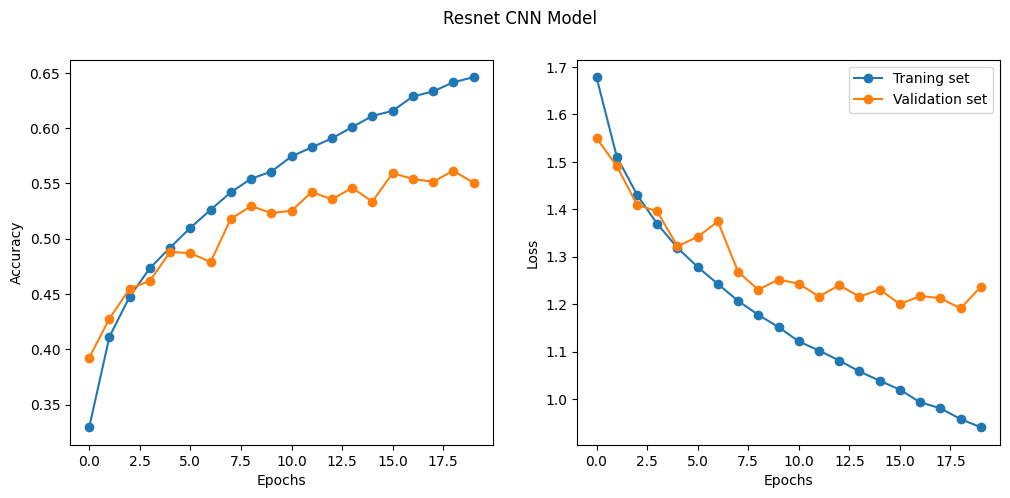

In [ ]:
plot_accuracy_loss(cnn_mod_info, "Resnet CNN Model")

### Model Testing

Accuracy is:                  0.57
Precision of each class is:   0.44 0.36 0.43 0.77 0.53 0.45 0.79
Recall of each class is:      0.51 0.52 0.37 0.8 0.49 0.48 0.64
F1_score of each class is:    0.47 0.43 0.4 0.78 0.51 0.46 0.7



Confusion Matrix


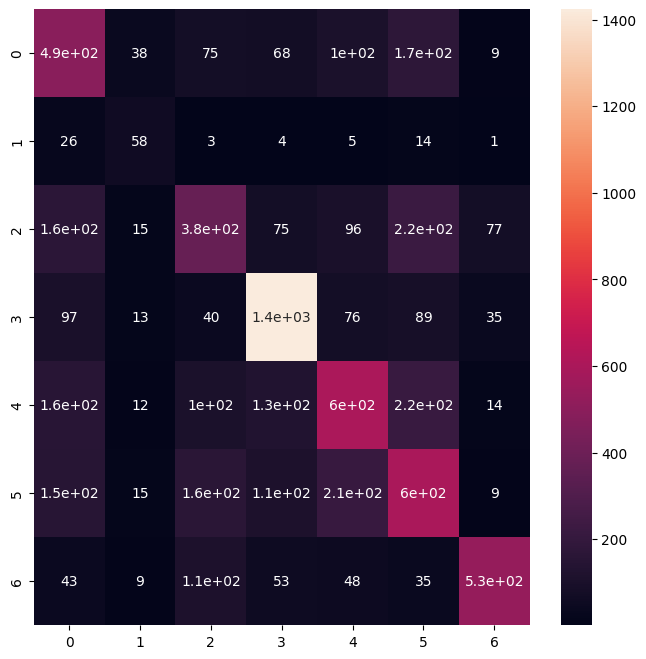

In [ ]:
model_testing(cnn_mod, criterion, test_dataloader)

In [ ]:
save_path=os.path.join(MODEL_WEIGHTS, "resnet_cnn_model.pth")
torch.save(cnn_mod, save_path)

# 3. ResUnet

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.res_block1 = ResidualBlock(64, 128, stride=2)
        self.res_block2 = ResidualBlock(128, 256, stride=2)

        # Decoder (U-Net-like structure)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_res_block1 = ResidualBlock(128, 64, stride=1)
        self.deconv2 = nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2)
        self.dec_res_block2 = ResidualBlock(64, 32, stride=1)
        self.conv3 = nn.Conv2d(96, 7, kernel_size=1, stride=2)
        self.fc = nn.Linear(4032, 7)


    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.res_block1(x)
        x = self.res_block2(x)

        # Decoder
        x = F.relu(self.deconv1(x))
        x = torch.cat([x, self.dec_res_block1(x)], dim=1)
        x = F.relu(self.deconv2(x))
        x = torch.cat([x, self.dec_res_block2(x)], dim=1)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

In [ ]:
#Saving model diagram
save_path=os.path.join(MODEL_DIAGRAM,"ResUnet_cnn_model")
model_graph = draw_graph(ResUNet(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/DeepLearning_2024/FaceRecognition/Model_diagrams/ResUnet_cnn_model.png'

### Model Training

In [ ]:
# Create a resnet CNN model
cnn_mod = ResUNet()

# Train your CNN Model
model = cnn_mod.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=25

cnn_mod, cnn_mod_info = model_training(num_epochs, model, optimizer, criterion, train_dataloader, val_dataloader, ResUNet)

  4%|▍         | 1/25 [00:47<18:58, 47.44s/it]

Epoch [1/25] : Train Loss: 1.7238, Val Loss: 1.6163,  Train Accuracy: 0.3039, Val Accuracy: 0.3664


  8%|▊         | 2/25 [01:37<18:41, 48.76s/it]

Epoch [2/25] : Train Loss: 1.5546, Val Loss: 1.4927,  Train Accuracy: 0.3953, Val Accuracy: 0.4294


 12%|█▏        | 3/25 [02:21<17:06, 46.67s/it]

Epoch [3/25] : Train Loss: 1.4469, Val Loss: 1.4134,  Train Accuracy: 0.4466, Val Accuracy: 0.4621


 16%|█▌        | 4/25 [03:05<15:58, 45.65s/it]

Epoch [4/25] : Train Loss: 1.3706, Val Loss: 1.3917,  Train Accuracy: 0.4715, Val Accuracy: 0.4781


 20%|██        | 5/25 [03:49<15:01, 45.06s/it]

Epoch [5/25] : Train Loss: 1.3207, Val Loss: 1.3100,  Train Accuracy: 0.4964, Val Accuracy: 0.5006


 24%|██▍       | 6/25 [04:33<14:11, 44.79s/it]

Epoch [6/25] : Train Loss: 1.2699, Val Loss: 1.2855,  Train Accuracy: 0.5161, Val Accuracy: 0.5120


 28%|██▊       | 7/25 [05:18<13:26, 44.80s/it]

Epoch [7/25] : Train Loss: 1.2389, Val Loss: 1.2813,  Train Accuracy: 0.5277, Val Accuracy: 0.5166


 32%|███▏      | 8/25 [06:02<12:35, 44.46s/it]

Epoch [8/25] : Train Loss: 1.2094, Val Loss: 1.2219,  Train Accuracy: 0.5398, Val Accuracy: 0.5341


 36%|███▌      | 9/25 [06:46<11:50, 44.43s/it]

Epoch [9/25] : Train Loss: 1.1813, Val Loss: 1.2195,  Train Accuracy: 0.5542, Val Accuracy: 0.5364


 40%|████      | 10/25 [07:30<11:02, 44.16s/it]

Epoch [10/25] : Train Loss: 1.1551, Val Loss: 1.2102,  Train Accuracy: 0.5637, Val Accuracy: 0.5329


 44%|████▍     | 11/25 [08:13<10:16, 44.02s/it]

Epoch [11/25] : Train Loss: 1.1309, Val Loss: 1.2027,  Train Accuracy: 0.5724, Val Accuracy: 0.5545


 48%|████▊     | 12/25 [08:58<09:35, 44.29s/it]

Epoch [12/25] : Train Loss: 1.1076, Val Loss: 1.1938,  Train Accuracy: 0.5843, Val Accuracy: 0.5478


 52%|█████▏    | 13/25 [09:43<08:51, 44.31s/it]

Epoch [13/25] : Train Loss: 1.0870, Val Loss: 1.2025,  Train Accuracy: 0.5930, Val Accuracy: 0.5463


 56%|█████▌    | 14/25 [10:26<08:05, 44.13s/it]

Epoch [14/25] : Train Loss: 1.0726, Val Loss: 1.1839,  Train Accuracy: 0.5950, Val Accuracy: 0.5525


 60%|██████    | 15/25 [11:10<07:19, 43.96s/it]

Epoch [15/25] : Train Loss: 1.0519, Val Loss: 1.1753,  Train Accuracy: 0.6030, Val Accuracy: 0.5627


 64%|██████▍   | 16/25 [11:53<06:34, 43.85s/it]

Epoch [16/25] : Train Loss: 1.0408, Val Loss: 1.1610,  Train Accuracy: 0.6118, Val Accuracy: 0.5665


 68%|██████▊   | 17/25 [12:38<05:52, 44.05s/it]

Epoch [17/25] : Train Loss: 1.0243, Val Loss: 1.1575,  Train Accuracy: 0.6161, Val Accuracy: 0.5730


 72%|███████▏  | 18/25 [13:24<05:11, 44.52s/it]

Epoch [18/25] : Train Loss: 1.0148, Val Loss: 1.1515,  Train Accuracy: 0.6191, Val Accuracy: 0.5697


 76%|███████▌  | 19/25 [14:08<04:26, 44.34s/it]

Epoch [19/25] : Train Loss: 0.9950, Val Loss: 1.1327,  Train Accuracy: 0.6277, Val Accuracy: 0.5805


 80%|████████  | 20/25 [14:51<03:40, 44.09s/it]

Epoch [20/25] : Train Loss: 0.9830, Val Loss: 1.1508,  Train Accuracy: 0.6323, Val Accuracy: 0.5779


 84%|████████▍ | 21/25 [15:37<02:58, 44.52s/it]

Epoch [21/25] : Train Loss: 0.9697, Val Loss: 1.1422,  Train Accuracy: 0.6374, Val Accuracy: 0.5720


 88%|████████▊ | 22/25 [16:20<02:12, 44.29s/it]

Epoch [22/25] : Train Loss: 0.9536, Val Loss: 1.1365,  Train Accuracy: 0.6445, Val Accuracy: 0.5836


 92%|█████████▏| 23/25 [17:05<01:29, 44.51s/it]

Epoch [23/25] : Train Loss: 0.9478, Val Loss: 1.1434,  Train Accuracy: 0.6453, Val Accuracy: 0.5808


 96%|█████████▌| 24/25 [17:49<00:44, 44.35s/it]

Epoch [24/25] : Train Loss: 0.9292, Val Loss: 1.1306,  Train Accuracy: 0.6551, Val Accuracy: 0.5837


100%|██████████| 25/25 [18:34<00:00, 44.56s/it]

Epoch [25/25] : Train Loss: 0.9170, Val Loss: 1.1314,  Train Accuracy: 0.6545, Val Accuracy: 0.5784


### Accuracy plots

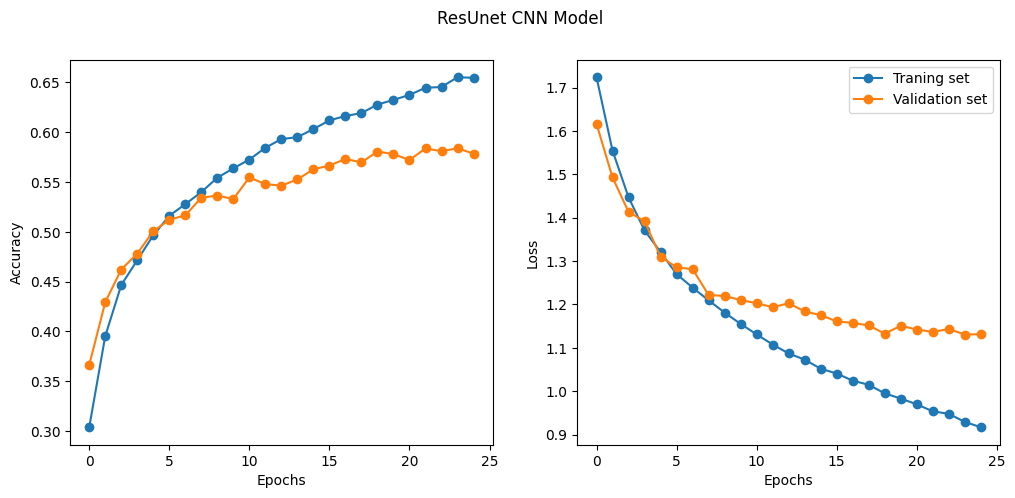

In [ ]:
plot_accuracy_loss(cnn_mod_info, "ResUnet CNN Model")

### Model Testing

Accuracy is:                  0.593
Precision of each class is:   0.51 0.59 0.39 0.83 0.54 0.44 0.77
Recall of each class is:      0.54 0.22 0.42 0.83 0.56 0.43 0.69
F1_score of each class is:    0.53 0.32 0.41 0.83 0.55 0.44 0.73



Confusion Matrix


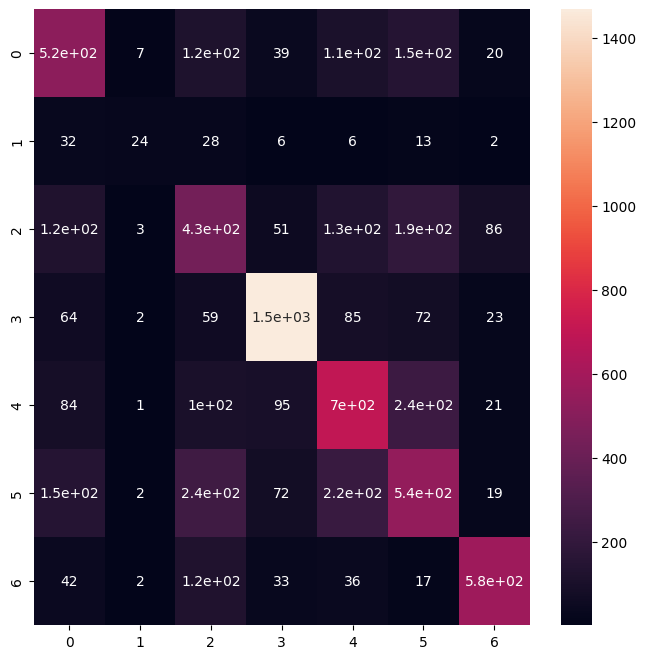

In [ ]:
model_testing(cnn_mod, criterion, test_dataloader)

In [ ]:
save_path=os.path.join(MODEL_WEIGHTS, "ResUnet_cnn_model.pth")
torch.save(cnn_mod, save_path)

# 4. ResUnet, with SGD optimizer

### Model Training

In [ ]:
# Create a resnet CNN model
cnn_mod = ResUNet()

# Train your CNN Model
model = cnn_mod.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs=25

cnn_mod, cnn_mod_info = model_training(num_epochs, model, optimizer, criterion, train_dataloader, val_dataloader, ResUNet)

  4%|▍         | 1/25 [00:43<17:23, 43.48s/it]

Epoch [1/25] : Train Loss: 1.7488, Val Loss: 1.6556,  Train Accuracy: 0.2873, Val Accuracy: 0.3598


  8%|▊         | 2/25 [01:29<17:17, 45.09s/it]

Epoch [2/25] : Train Loss: 1.6095, Val Loss: 1.5461,  Train Accuracy: 0.3734, Val Accuracy: 0.4040


 12%|█▏        | 3/25 [02:23<17:56, 48.92s/it]

Epoch [3/25] : Train Loss: 1.5231, Val Loss: 1.4967,  Train Accuracy: 0.4102, Val Accuracy: 0.4249


 16%|█▌        | 4/25 [03:21<18:23, 52.57s/it]

Epoch [4/25] : Train Loss: 1.4609, Val Loss: 1.4552,  Train Accuracy: 0.4376, Val Accuracy: 0.4400


 20%|██        | 5/25 [04:17<17:54, 53.74s/it]

Epoch [5/25] : Train Loss: 1.4075, Val Loss: 1.4291,  Train Accuracy: 0.4642, Val Accuracy: 0.4588


 24%|██▍       | 6/25 [05:02<16:05, 50.81s/it]

Epoch [6/25] : Train Loss: 1.3576, Val Loss: 1.3663,  Train Accuracy: 0.4835, Val Accuracy: 0.4765


 28%|██▊       | 7/25 [05:45<14:31, 48.42s/it]

Epoch [7/25] : Train Loss: 1.3232, Val Loss: 1.3424,  Train Accuracy: 0.4961, Val Accuracy: 0.4954


 32%|███▏      | 8/25 [06:29<13:16, 46.87s/it]

Epoch [8/25] : Train Loss: 1.2901, Val Loss: 1.3033,  Train Accuracy: 0.5085, Val Accuracy: 0.5032


 36%|███▌      | 9/25 [07:14<12:19, 46.24s/it]

Epoch [9/25] : Train Loss: 1.2616, Val Loss: 1.2990,  Train Accuracy: 0.5200, Val Accuracy: 0.5085


 40%|████      | 10/25 [07:58<11:24, 45.66s/it]

Epoch [10/25] : Train Loss: 1.2294, Val Loss: 1.2764,  Train Accuracy: 0.5305, Val Accuracy: 0.5220


 44%|████▍     | 11/25 [08:42<10:33, 45.22s/it]

Epoch [11/25] : Train Loss: 1.2109, Val Loss: 1.2450,  Train Accuracy: 0.5466, Val Accuracy: 0.5290


 48%|████▊     | 12/25 [09:28<09:50, 45.43s/it]

Epoch [12/25] : Train Loss: 1.1845, Val Loss: 1.2505,  Train Accuracy: 0.5564, Val Accuracy: 0.5300


 52%|█████▏    | 13/25 [10:12<08:58, 44.91s/it]

Epoch [13/25] : Train Loss: 1.1706, Val Loss: 1.2353,  Train Accuracy: 0.5588, Val Accuracy: 0.5383


 56%|█████▌    | 14/25 [10:57<08:13, 44.89s/it]

Epoch [14/25] : Train Loss: 1.1482, Val Loss: 1.2118,  Train Accuracy: 0.5694, Val Accuracy: 0.5435


 60%|██████    | 15/25 [11:41<07:25, 44.59s/it]

Epoch [15/25] : Train Loss: 1.1417, Val Loss: 1.2301,  Train Accuracy: 0.5710, Val Accuracy: 0.5389


 64%|██████▍   | 16/25 [12:24<06:38, 44.31s/it]

Epoch [16/25] : Train Loss: 1.1171, Val Loss: 1.2068,  Train Accuracy: 0.5817, Val Accuracy: 0.5465


 68%|██████▊   | 17/25 [13:08<05:52, 44.08s/it]

Epoch [17/25] : Train Loss: 1.1114, Val Loss: 1.2288,  Train Accuracy: 0.5800, Val Accuracy: 0.5422


 72%|███████▏  | 18/25 [13:52<05:08, 44.08s/it]

Epoch [18/25] : Train Loss: 1.0918, Val Loss: 1.1987,  Train Accuracy: 0.5852, Val Accuracy: 0.5561


 76%|███████▌  | 19/25 [14:35<04:23, 43.88s/it]

Epoch [19/25] : Train Loss: 1.0786, Val Loss: 1.2010,  Train Accuracy: 0.5933, Val Accuracy: 0.5596


 80%|████████  | 20/25 [15:19<03:39, 43.90s/it]

Epoch [20/25] : Train Loss: 1.0647, Val Loss: 1.2023,  Train Accuracy: 0.6016, Val Accuracy: 0.5451


 84%|████████▍ | 21/25 [16:03<02:55, 43.92s/it]

Epoch [21/25] : Train Loss: 1.0591, Val Loss: 1.1916,  Train Accuracy: 0.6023, Val Accuracy: 0.5497


 88%|████████▊ | 22/25 [16:48<02:12, 44.07s/it]

Epoch [22/25] : Train Loss: 1.0432, Val Loss: 1.1872,  Train Accuracy: 0.6100, Val Accuracy: 0.5511


 92%|█████████▏| 23/25 [17:31<01:27, 43.91s/it]

Epoch [23/25] : Train Loss: 1.0324, Val Loss: 1.1825,  Train Accuracy: 0.6159, Val Accuracy: 0.5612


 96%|█████████▌| 24/25 [18:15<00:43, 43.73s/it]

Epoch [24/25] : Train Loss: 1.0293, Val Loss: 1.1667,  Train Accuracy: 0.6150, Val Accuracy: 0.5600


100%|██████████| 25/25 [18:58<00:00, 45.53s/it]

Epoch [25/25] : Train Loss: 1.0167, Val Loss: 1.1755,  Train Accuracy: 0.6200, Val Accuracy: 0.5642


### Accuracy plots

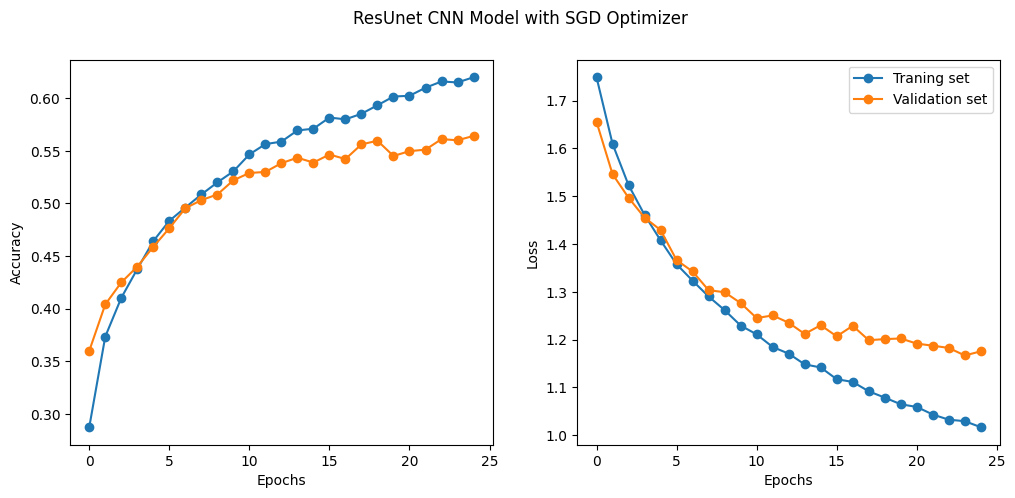

In [ ]:
plot_accuracy_loss(cnn_mod_info, "ResUnet CNN Model with SGD Optimizer")

### Model Testing

Accuracy is:                  0.575
Precision of each class is:   0.58 0.64 0.39 0.8 0.49 0.42 0.68
Recall of each class is:      0.35 0.25 0.29 0.82 0.58 0.54 0.76
F1_score of each class is:    0.43 0.36 0.33 0.81 0.53 0.47 0.72



Confusion Matrix


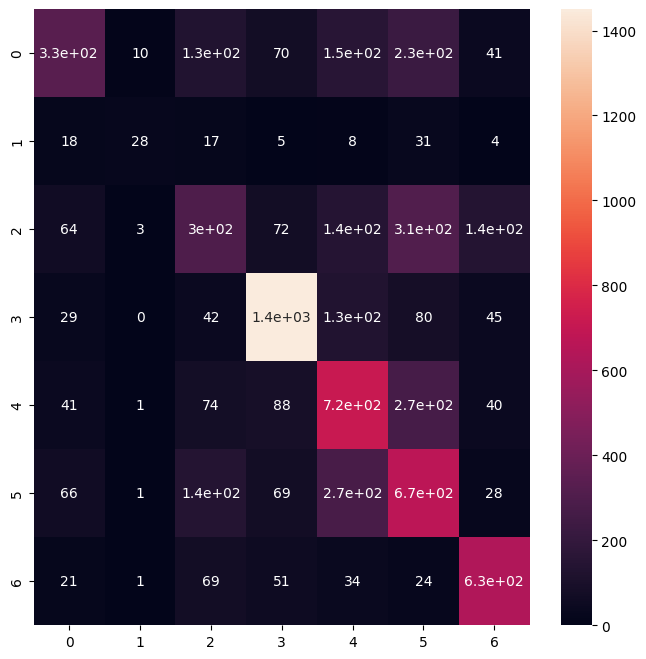

In [ ]:
model_testing(cnn_mod, criterion, test_dataloader)

# 5. ResUnet, with weighted loss function

In [26]:
class CustomLoss(nn.Module):
    def __init__(self, class_weights):
        super(CustomLoss, self).__init__()
        self.weights = torch.Tensor(class_weights).to(device)

    def forward(self, outputs, targets):
        loss = nn.CrossEntropyLoss(weight=self.weights)(outputs, targets)
        return loss

### Model Training

In [ ]:
# Create a resnet CNN model
cnn_mod = ResUNet()

# Train your CNN Model
model = cnn_mod.to(device)

criterion = CustomLoss([0.8, 1.3, 0.8, 0.5, 0.8, 0.8, 0.9])
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=25

cnn_mod, cnn_mod_info = model_training(num_epochs, model, optimizer, criterion, train_dataloader, val_dataloader, ResUNet)

  4%|▍         | 1/25 [00:44<17:42, 44.26s/it]

Epoch [1/25] : Train Loss: 1.7816, Val Loss: 1.6868,  Train Accuracy: 0.2753, Val Accuracy: 0.3512


  8%|▊         | 2/25 [01:27<16:47, 43.81s/it]

Epoch [2/25] : Train Loss: 1.6469, Val Loss: 1.5917,  Train Accuracy: 0.3713, Val Accuracy: 0.3986


 12%|█▏        | 3/25 [02:11<16:03, 43.78s/it]

Epoch [3/25] : Train Loss: 1.5430, Val Loss: 1.5382,  Train Accuracy: 0.4214, Val Accuracy: 0.4386


 16%|█▌        | 4/25 [02:55<15:21, 43.86s/it]

Epoch [4/25] : Train Loss: 1.4617, Val Loss: 1.4617,  Train Accuracy: 0.4596, Val Accuracy: 0.4632


 20%|██        | 5/25 [03:40<14:47, 44.38s/it]

Epoch [5/25] : Train Loss: 1.3996, Val Loss: 1.4255,  Train Accuracy: 0.4879, Val Accuracy: 0.4760


 24%|██▍       | 6/25 [04:24<13:59, 44.17s/it]

Epoch [6/25] : Train Loss: 1.3531, Val Loss: 1.3914,  Train Accuracy: 0.4990, Val Accuracy: 0.4772


 28%|██▊       | 7/25 [05:08<13:13, 44.06s/it]

Epoch [7/25] : Train Loss: 1.3112, Val Loss: 1.3282,  Train Accuracy: 0.5195, Val Accuracy: 0.5185


 32%|███▏      | 8/25 [05:51<12:26, 43.92s/it]

Epoch [8/25] : Train Loss: 1.2797, Val Loss: 1.3486,  Train Accuracy: 0.5337, Val Accuracy: 0.5099


 36%|███▌      | 9/25 [06:35<11:39, 43.72s/it]

Epoch [9/25] : Train Loss: 1.2504, Val Loss: 1.2912,  Train Accuracy: 0.5435, Val Accuracy: 0.5319


 40%|████      | 10/25 [07:19<10:58, 43.93s/it]

Epoch [10/25] : Train Loss: 1.2240, Val Loss: 1.2993,  Train Accuracy: 0.5547, Val Accuracy: 0.5362


 44%|████▍     | 11/25 [08:03<10:14, 43.87s/it]

Epoch [11/25] : Train Loss: 1.1979, Val Loss: 1.2598,  Train Accuracy: 0.5634, Val Accuracy: 0.5393


 48%|████▊     | 12/25 [08:47<09:31, 44.00s/it]

Epoch [12/25] : Train Loss: 1.1810, Val Loss: 1.2829,  Train Accuracy: 0.5683, Val Accuracy: 0.5306


 52%|█████▏    | 13/25 [09:31<08:47, 43.96s/it]

Epoch [13/25] : Train Loss: 1.1572, Val Loss: 1.2619,  Train Accuracy: 0.5864, Val Accuracy: 0.5449


 56%|█████▌    | 14/25 [10:16<08:06, 44.21s/it]

Epoch [14/25] : Train Loss: 1.1324, Val Loss: 1.2414,  Train Accuracy: 0.5907, Val Accuracy: 0.5488


 60%|██████    | 15/25 [10:59<07:20, 44.02s/it]

Epoch [15/25] : Train Loss: 1.1154, Val Loss: 1.2319,  Train Accuracy: 0.5968, Val Accuracy: 0.5634


 64%|██████▍   | 16/25 [11:43<06:34, 43.87s/it]

Epoch [16/25] : Train Loss: 1.1043, Val Loss: 1.2435,  Train Accuracy: 0.5986, Val Accuracy: 0.5556


 68%|██████▊   | 17/25 [12:26<05:49, 43.73s/it]

Epoch [17/25] : Train Loss: 1.0790, Val Loss: 1.2203,  Train Accuracy: 0.6099, Val Accuracy: 0.5595


 72%|███████▏  | 18/25 [13:11<05:07, 43.93s/it]

Epoch [18/25] : Train Loss: 1.0720, Val Loss: 1.2092,  Train Accuracy: 0.6131, Val Accuracy: 0.5697


 76%|███████▌  | 19/25 [13:54<04:23, 43.85s/it]

Epoch [19/25] : Train Loss: 1.0541, Val Loss: 1.2282,  Train Accuracy: 0.6196, Val Accuracy: 0.5560


 80%|████████  | 20/25 [14:39<03:39, 43.97s/it]

Epoch [20/25] : Train Loss: 1.0367, Val Loss: 1.2335,  Train Accuracy: 0.6286, Val Accuracy: 0.5680


 84%|████████▍ | 21/25 [15:23<02:55, 44.00s/it]

Epoch [21/25] : Train Loss: 1.0245, Val Loss: 1.1985,  Train Accuracy: 0.6312, Val Accuracy: 0.5719


 88%|████████▊ | 22/25 [16:08<02:12, 44.25s/it]

Epoch [22/25] : Train Loss: 1.0000, Val Loss: 1.2285,  Train Accuracy: 0.6399, Val Accuracy: 0.5705


 92%|█████████▏| 23/25 [16:51<01:28, 44.12s/it]

Epoch [23/25] : Train Loss: 0.9955, Val Loss: 1.2130,  Train Accuracy: 0.6451, Val Accuracy: 0.5702


 96%|█████████▌| 24/25 [17:35<00:43, 43.96s/it]

Epoch [24/25] : Train Loss: 0.9878, Val Loss: 1.2032,  Train Accuracy: 0.6444, Val Accuracy: 0.5687


100%|██████████| 25/25 [18:18<00:00, 43.96s/it]

Epoch [25/25] : Train Loss: 0.9627, Val Loss: 1.2223,  Train Accuracy: 0.6573, Val Accuracy: 0.5759


### Accuracy plots

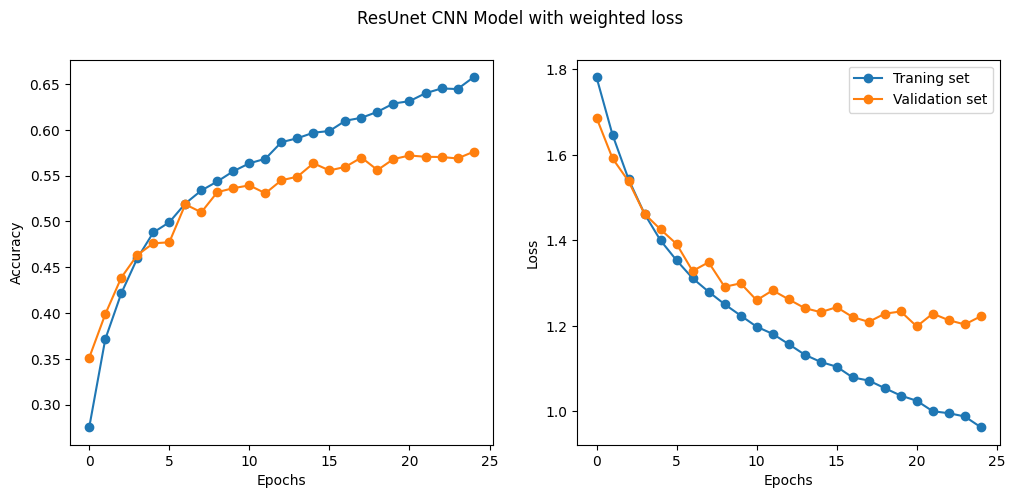

In [ ]:
plot_accuracy_loss(cnn_mod_info, "ResUnet CNN Model with weighted loss")

### Model Testing

Accuracy is:                  0.603
Precision of each class is:   0.55 0.43 0.45 0.83 0.5 0.49 0.7
Recall of each class is:      0.47 0.47 0.33 0.82 0.66 0.47 0.76
F1_score of each class is:    0.51 0.45 0.38 0.82 0.57 0.48 0.73



Confusion Matrix


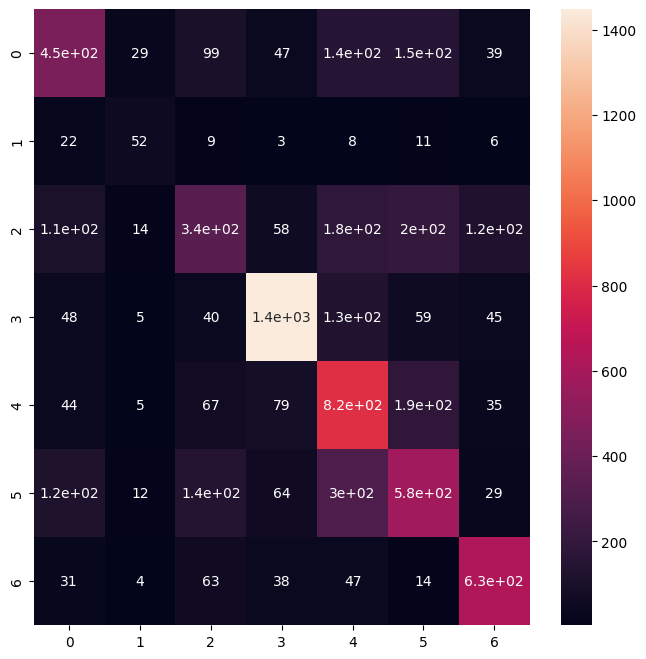

In [ ]:
model_testing(cnn_mod, criterion, test_dataloader)

In [ ]:
save_path=os.path.join(MODEL_WEIGHTS, "ResUnet_weighted_loss_cnn_model.pth")
torch.save(cnn_mod, save_path)

# 6. GoogleNet

In [23]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1_output = self.branch1(x)
        branch2_output = self.branch2(x)
        branch3_output = self.branch3(x)
        branch4_output = self.branch4(x)
        output = torch.cat([branch1_output, branch2_output, branch3_output, branch4_output], 1)
        return output

class GoogleNet(nn.Module):
    def __init__(self, num_classes=7):
        super(GoogleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.maxpool2(F.relu(self.conv3(x)))
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [32]:
#Saving model diagram
save_path=os.path.join(MODEL_DIAGRAM,"GoogleNet_cnn_model")
model_graph = draw_graph(GoogleNet(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/DeepLearning_2024/FaceRecognition/Model_diagrams/GoogleNet_cnn_model.png'

### Model Training

In [27]:
# Create a GoogleNet CNN model
cnn_mod = GoogleNet()

# Train your CNN Model
model = cnn_mod.to(device)

criterion = CustomLoss([0.8, 1.3, 0.8, 0.5, 0.8, 0.8, 0.9])
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=25

cnn_mod, cnn_mod_info = model_training(num_epochs, model, optimizer, criterion, train_dataloader, val_dataloader, GoogleNet)

  4%|▍         | 1/25 [00:34<13:45, 34.38s/it]

Epoch [1/25] : Train Loss: 1.8569, Val Loss: 1.8497,  Train Accuracy: 0.1903, Val Accuracy: 0.1840


  8%|▊         | 2/25 [01:11<13:52, 36.18s/it]

Epoch [2/25] : Train Loss: 1.8336, Val Loss: 1.8024,  Train Accuracy: 0.1992, Val Accuracy: 0.2165


 12%|█▏        | 3/25 [02:08<16:40, 45.47s/it]

Epoch [3/25] : Train Loss: 1.7593, Val Loss: 1.7271,  Train Accuracy: 0.2393, Val Accuracy: 0.2565


 16%|█▌        | 4/25 [02:40<14:04, 40.23s/it]

Epoch [4/25] : Train Loss: 1.6988, Val Loss: 1.6672,  Train Accuracy: 0.2735, Val Accuracy: 0.3373


 20%|██        | 5/25 [03:18<13:05, 39.28s/it]

Epoch [5/25] : Train Loss: 1.6462, Val Loss: 1.6105,  Train Accuracy: 0.3401, Val Accuracy: 0.3649


 24%|██▍       | 6/25 [03:54<12:05, 38.18s/it]

Epoch [6/25] : Train Loss: 1.5653, Val Loss: 1.5457,  Train Accuracy: 0.3984, Val Accuracy: 0.4211


 28%|██▊       | 7/25 [04:26<10:53, 36.29s/it]

Epoch [7/25] : Train Loss: 1.4968, Val Loss: 1.4674,  Train Accuracy: 0.4373, Val Accuracy: 0.4490


 32%|███▏      | 8/25 [05:02<10:16, 36.25s/it]

Epoch [8/25] : Train Loss: 1.4494, Val Loss: 1.4335,  Train Accuracy: 0.4567, Val Accuracy: 0.4546


 36%|███▌      | 9/25 [05:35<09:22, 35.14s/it]

Epoch [9/25] : Train Loss: 1.4170, Val Loss: 1.4065,  Train Accuracy: 0.4709, Val Accuracy: 0.4706


 40%|████      | 10/25 [06:07<08:31, 34.09s/it]

Epoch [10/25] : Train Loss: 1.3873, Val Loss: 1.4195,  Train Accuracy: 0.4832, Val Accuracy: 0.4618


 44%|████▍     | 11/25 [06:39<07:50, 33.59s/it]

Epoch [11/25] : Train Loss: 1.3588, Val Loss: 1.3877,  Train Accuracy: 0.4962, Val Accuracy: 0.4859


 48%|████▊     | 12/25 [07:12<07:12, 33.26s/it]

Epoch [12/25] : Train Loss: 1.3440, Val Loss: 1.3628,  Train Accuracy: 0.4987, Val Accuracy: 0.4954


 52%|█████▏    | 13/25 [07:43<06:34, 32.83s/it]

Epoch [13/25] : Train Loss: 1.3264, Val Loss: 1.3403,  Train Accuracy: 0.5112, Val Accuracy: 0.4961


 56%|█████▌    | 14/25 [08:15<05:57, 32.53s/it]

Epoch [14/25] : Train Loss: 1.2965, Val Loss: 1.3238,  Train Accuracy: 0.5237, Val Accuracy: 0.5152


 60%|██████    | 15/25 [08:48<05:26, 32.61s/it]

Epoch [15/25] : Train Loss: 1.2807, Val Loss: 1.3128,  Train Accuracy: 0.5284, Val Accuracy: 0.5092


 64%|██████▍   | 16/25 [09:20<04:51, 32.40s/it]

Epoch [16/25] : Train Loss: 1.2653, Val Loss: 1.3186,  Train Accuracy: 0.5371, Val Accuracy: 0.5074


 68%|██████▊   | 17/25 [09:52<04:18, 32.29s/it]

Epoch [17/25] : Train Loss: 1.2505, Val Loss: 1.2829,  Train Accuracy: 0.5420, Val Accuracy: 0.5255


 72%|███████▏  | 18/25 [10:43<04:25, 37.93s/it]

Epoch [18/25] : Train Loss: 1.2317, Val Loss: 1.2938,  Train Accuracy: 0.5488, Val Accuracy: 0.5142


 76%|███████▌  | 19/25 [11:29<04:02, 40.36s/it]

Epoch [19/25] : Train Loss: 1.2179, Val Loss: 1.2704,  Train Accuracy: 0.5571, Val Accuracy: 0.5418


 80%|████████  | 20/25 [12:01<03:08, 37.80s/it]

Epoch [20/25] : Train Loss: 1.2019, Val Loss: 1.2682,  Train Accuracy: 0.5604, Val Accuracy: 0.5383


 84%|████████▍ | 21/25 [12:34<02:25, 36.30s/it]

Epoch [21/25] : Train Loss: 1.1847, Val Loss: 1.2778,  Train Accuracy: 0.5713, Val Accuracy: 0.5302


 88%|████████▊ | 22/25 [13:06<01:44, 34.97s/it]

Epoch [22/25] : Train Loss: 1.1775, Val Loss: 1.2663,  Train Accuracy: 0.5761, Val Accuracy: 0.5385


 92%|█████████▏| 23/25 [13:38<01:08, 34.10s/it]

Epoch [23/25] : Train Loss: 1.1566, Val Loss: 1.2479,  Train Accuracy: 0.5799, Val Accuracy: 0.5390


 96%|█████████▌| 24/25 [14:10<00:33, 33.54s/it]

Epoch [24/25] : Train Loss: 1.1452, Val Loss: 1.2610,  Train Accuracy: 0.5848, Val Accuracy: 0.5469


100%|██████████| 25/25 [14:42<00:00, 35.31s/it]

Epoch [25/25] : Train Loss: 1.1408, Val Loss: 1.2576,  Train Accuracy: 0.5845, Val Accuracy: 0.5397


### Accuracy plots

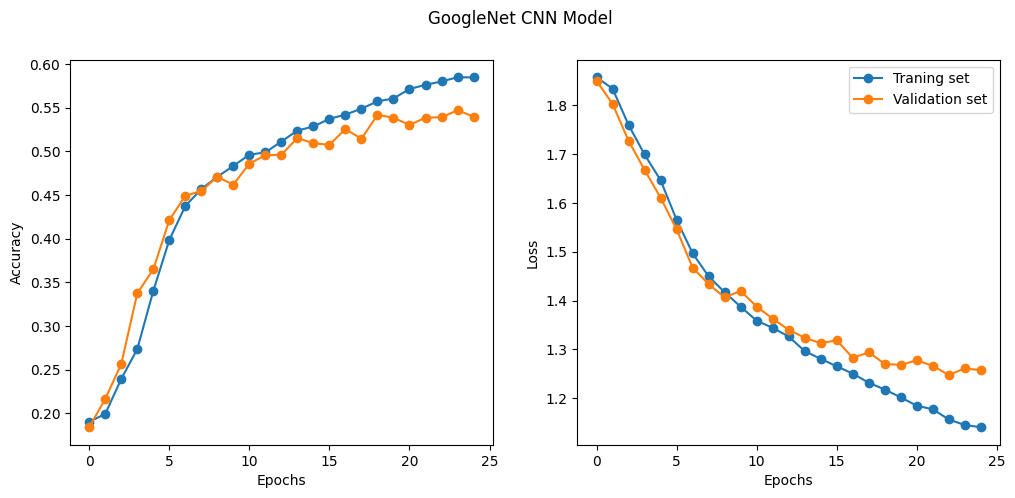

In [28]:
plot_accuracy_loss(cnn_mod_info, "GoogleNet CNN Model")

### Model Testing

Accuracy is:                  0.556
Precision of each class is:   0.41 0.38 0.36 0.82 0.58 0.43 0.65
Recall of each class is:      0.57 0.23 0.33 0.77 0.45 0.44 0.74
F1_score of each class is:    0.47 0.29 0.34 0.8 0.51 0.44 0.69



Confusion Matrix


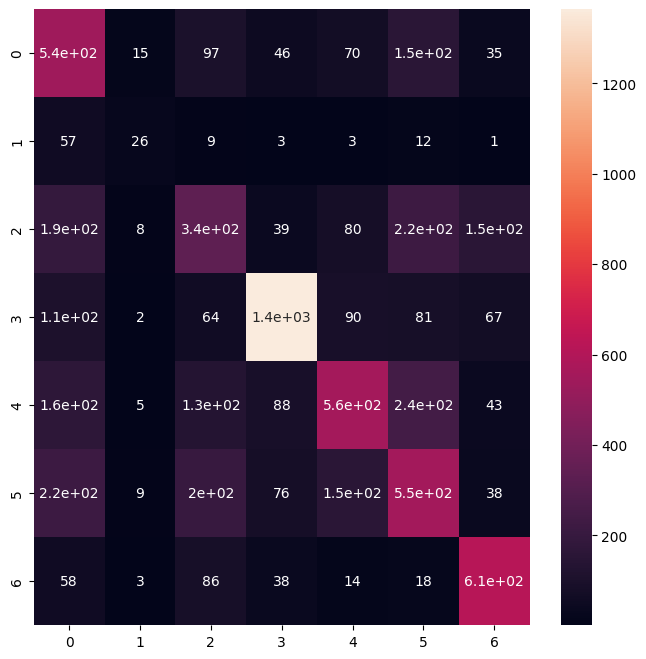

In [30]:
model_testing(cnn_mod, criterion, test_dataloader)

In [29]:
save_path=os.path.join(MODEL_WEIGHTS, "GoogleNet_cnn_model.pth")
torch.save(cnn_mod, save_path)

# 7. MobileNetVariation

In [53]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = F.relu(x)
        x = self.pointwise(x)
        return x

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SqueezeExcitation, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)

    def forward(self, x):
        scale = self.avg_pool(x)
        scale = F.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return scale * x

class ResidualDepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualDepthwiseSeparableConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = DepthwiseSeparableConv(out_channels, out_channels, stride=stride)
        self.se = SqueezeExcitation(out_channels)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.se(x)
        if x.shape == residual.shape:
            x += residual
        return x

class MobileNetVariation(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetVariation, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.blocks = nn.Sequential(
            ResidualDepthwiseSeparableConv(32, 64, stride=1),
            ResidualDepthwiseSeparableConv(64, 128, stride=2),
            ResidualDepthwiseSeparableConv(128, 128, stride=1),
            ResidualDepthwiseSeparableConv(128, 256, stride=2),
            ResidualDepthwiseSeparableConv(256, 256, stride=1),
            ResidualDepthwiseSeparableConv(256, 512, stride=2),
            ResidualDepthwiseSeparableConv(512, 512, stride=1),
            ResidualDepthwiseSeparableConv(512, 512, stride=1),
            ResidualDepthwiseSeparableConv(512, 512, stride=1),
            ResidualDepthwiseSeparableConv(512, 512, stride=1),
            ResidualDepthwiseSeparableConv(512, 512, stride=1),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.blocks(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [54]:
#Saving model diagram
save_path=os.path.join(MODEL_DIAGRAM,"MobileNetVariation_cnn_model")
model_graph = draw_graph(MobileNetVariation(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/DeepLearning_2024/FaceRecognition/Model_diagrams/MobileNetVariation_cnn_model.png'

### Model Training

In [55]:
# Create a GoogleNet CNN model
cnn_mod = MobileNetVariation()

# Train your CNN Model
model = cnn_mod.to(device)

criterion = CustomLoss([0.8, 1.3, 0.8, 0.5, 0.8, 0.8, 0.9])
optimizer = optim.Adam(model.parameters(), lr=0.0002)
num_epochs=25

cnn_mod, cnn_mod_info = model_training(num_epochs, model, optimizer, criterion, train_dataloader, val_dataloader, MobileNetVariation)

  4%|▍         | 1/25 [00:36<14:34, 36.44s/it]

Epoch [1/25] : Train Loss: 1.8597, Val Loss: 1.8377,  Train Accuracy: 0.1848, Val Accuracy: 0.2138


  8%|▊         | 2/25 [01:08<13:01, 33.98s/it]

Epoch [2/25] : Train Loss: 1.8269, Val Loss: 1.8202,  Train Accuracy: 0.2235, Val Accuracy: 0.2471


 12%|█▏        | 3/25 [01:41<12:15, 33.45s/it]

Epoch [3/25] : Train Loss: 1.7826, Val Loss: 1.7566,  Train Accuracy: 0.2883, Val Accuracy: 0.3057


 16%|█▌        | 4/25 [02:14<11:42, 33.44s/it]

Epoch [4/25] : Train Loss: 1.7361, Val Loss: 1.7175,  Train Accuracy: 0.3221, Val Accuracy: 0.3299


 20%|██        | 5/25 [02:47<11:00, 33.02s/it]

Epoch [5/25] : Train Loss: 1.6886, Val Loss: 1.6700,  Train Accuracy: 0.3514, Val Accuracy: 0.3601


 24%|██▍       | 6/25 [03:21<10:32, 33.30s/it]

Epoch [6/25] : Train Loss: 1.6424, Val Loss: 1.6410,  Train Accuracy: 0.3758, Val Accuracy: 0.3665


 28%|██▊       | 7/25 [03:53<09:53, 32.97s/it]

Epoch [7/25] : Train Loss: 1.6123, Val Loss: 1.6233,  Train Accuracy: 0.3879, Val Accuracy: 0.3915


 32%|███▏      | 8/25 [04:25<09:17, 32.82s/it]

Epoch [8/25] : Train Loss: 1.5840, Val Loss: 1.5942,  Train Accuracy: 0.4010, Val Accuracy: 0.3951


 36%|███▌      | 9/25 [04:58<08:44, 32.77s/it]

Epoch [9/25] : Train Loss: 1.5594, Val Loss: 1.5735,  Train Accuracy: 0.4161, Val Accuracy: 0.4108


 40%|████      | 10/25 [05:30<08:06, 32.45s/it]

Epoch [10/25] : Train Loss: 1.5418, Val Loss: 1.5483,  Train Accuracy: 0.4195, Val Accuracy: 0.4100


 44%|████▍     | 11/25 [06:03<07:36, 32.62s/it]

Epoch [11/25] : Train Loss: 1.5163, Val Loss: 1.5608,  Train Accuracy: 0.4344, Val Accuracy: 0.4033


 48%|████▊     | 12/25 [06:35<07:03, 32.60s/it]

Epoch [12/25] : Train Loss: 1.4983, Val Loss: 1.5215,  Train Accuracy: 0.4389, Val Accuracy: 0.4209


 52%|█████▏    | 13/25 [07:07<06:29, 32.47s/it]

Epoch [13/25] : Train Loss: 1.4779, Val Loss: 1.5045,  Train Accuracy: 0.4464, Val Accuracy: 0.4335


 56%|█████▌    | 14/25 [07:40<05:58, 32.57s/it]

Epoch [14/25] : Train Loss: 1.4639, Val Loss: 1.4865,  Train Accuracy: 0.4537, Val Accuracy: 0.4400


 60%|██████    | 15/25 [08:12<05:24, 32.42s/it]

Epoch [15/25] : Train Loss: 1.4435, Val Loss: 1.4840,  Train Accuracy: 0.4622, Val Accuracy: 0.4511


 64%|██████▍   | 16/25 [08:44<04:50, 32.28s/it]

Epoch [16/25] : Train Loss: 1.4303, Val Loss: 1.4750,  Train Accuracy: 0.4690, Val Accuracy: 0.4515


 68%|██████▊   | 17/25 [09:17<04:19, 32.46s/it]

Epoch [17/25] : Train Loss: 1.4073, Val Loss: 1.5021,  Train Accuracy: 0.4777, Val Accuracy: 0.4313


 72%|███████▏  | 18/25 [09:49<03:46, 32.36s/it]

Epoch [18/25] : Train Loss: 1.3953, Val Loss: 1.4619,  Train Accuracy: 0.4808, Val Accuracy: 0.4606


 76%|███████▌  | 19/25 [10:22<03:14, 32.46s/it]

Epoch [19/25] : Train Loss: 1.3826, Val Loss: 1.4604,  Train Accuracy: 0.4857, Val Accuracy: 0.4592


 80%|████████  | 20/25 [10:55<02:43, 32.62s/it]

Epoch [20/25] : Train Loss: 1.3671, Val Loss: 1.4533,  Train Accuracy: 0.4920, Val Accuracy: 0.4629


 84%|████████▍ | 21/25 [11:27<02:10, 32.54s/it]

Epoch [21/25] : Train Loss: 1.3509, Val Loss: 1.4336,  Train Accuracy: 0.5015, Val Accuracy: 0.4564


 88%|████████▊ | 22/25 [12:01<01:38, 32.78s/it]

Epoch [22/25] : Train Loss: 1.3440, Val Loss: 1.4430,  Train Accuracy: 0.4968, Val Accuracy: 0.4678


 92%|█████████▏| 23/25 [12:33<01:05, 32.66s/it]

Epoch [23/25] : Train Loss: 1.3244, Val Loss: 1.4187,  Train Accuracy: 0.5109, Val Accuracy: 0.4767


 96%|█████████▌| 24/25 [13:05<00:32, 32.57s/it]

Epoch [24/25] : Train Loss: 1.3157, Val Loss: 1.4283,  Train Accuracy: 0.5128, Val Accuracy: 0.4719


100%|██████████| 25/25 [13:39<00:00, 32.77s/it]

Epoch [25/25] : Train Loss: 1.2940, Val Loss: 1.4507,  Train Accuracy: 0.5219, Val Accuracy: 0.4713


### Accuracy plots

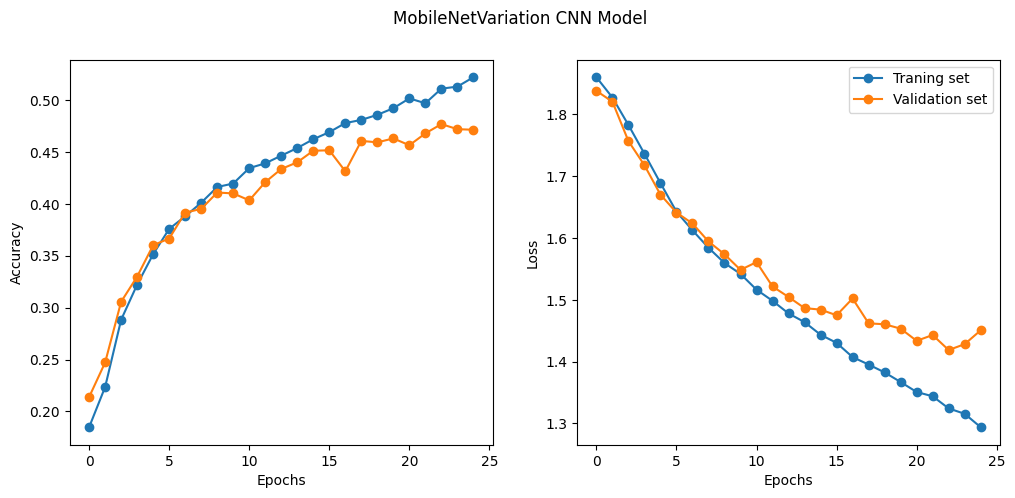

In [56]:
plot_accuracy_loss(cnn_mod_info, "MobileNetVariation CNN Model")

### Model Testing

Accuracy is:                  0.493
Precision of each class is:   0.44 0.41 0.35 0.63 0.4 0.38 0.55
Recall of each class is:      0.27 0.08 0.19 0.78 0.54 0.34 0.72
F1_score of each class is:    0.34 0.14 0.24 0.7 0.46 0.36 0.63



Confusion Matrix


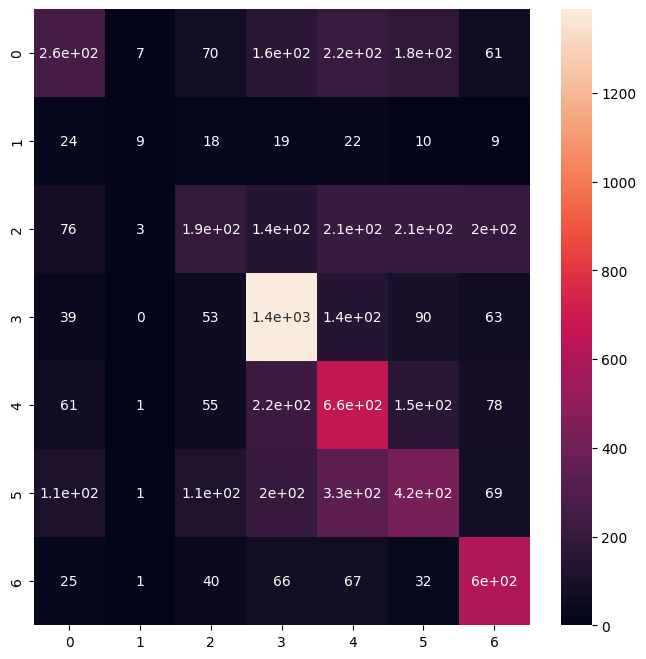

In [57]:
model_testing(cnn_mod, criterion, test_dataloader)

In [58]:
save_path=os.path.join(MODEL_WEIGHTS, "MobileNetVariation_cnn_model.pth")
torch.save(cnn_mod, save_path)